##  **Analysing PCA Variations in Hypertrophic Cardiomyopathy Patients**

This code is to explore developing PCA variations on a single frame. 
- We are taking only the End-Diastolic frame, which is always the first frame *(e.g. HCMR_abc_efg_Model_Frame_000.txt)*
- The PCA is going to be performed on the control point matrix (not the surface points), which means we are going to use 388 vertices as the input for PCA.  

For 100 patients, our input will be 100 x 1,164 matrix because the row will be [x1, y1, z1, x2, y2, z2, ..., x388, y388, z388] vector. 

We will calculate the average or mean shape by using the Procrustes analysis. 
When we are doing the Procrustes analysis, we will be keeping the size. This means we are aligning the shapes using orientation and translation only.
- The reason for keeping the size because size is a clinical factor for heart disease. So we don’t want to remove it from the data. 

We will then be visualising the mean shape. 

Then we will perform the PCA on after subtracting each patient shape with the mean shape while retaining only the first 5 principal components for the analysis. 
And we will analyse how the modes of shape variations from the first 5 principal components (between –2 SD to +2 SD).

In [1]:
# Importing all the required libraries and file directories

import os
import numpy as np
from pathlib import Path
import shutil
import pandas as pd
from loguru import logger
from typing import List
import matplotlib.pyplot as plt
import pyvista as pv
import pyvista as pv
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

1) Taking only the End Diastolic (ED) Frame from the data set and putting them all into one folder called 'ed_models' for easier analysis:
- *Ignored HCMR_002_0020_Model_Frame_000.txt as it was found to be a faulty file*

In [2]:
data_dir = Path('.')  # Set the data directory to the current directory

# Function to ignore faulty files
def should_ignore_file(filename):
    """Check if filename contains 'ignore' (case-insensitive)"""
    return 'ignore' in filename.lower()

# Create the folder
Path('./ed_models/').mkdir(exist_ok=True)

# Get only the first frame (ED frame) model
ed_models = list(Path('../HCMR_100_1/').glob('HCMR_*/HCMR_*_Frame_000.txt'))
print(f"Found {len(ed_models)} ED models before filtering")

# Copy ED models to the new folder (ignoring files with 'ignore' in name)
copied_count = 0
for ed_file in ed_models:
    if not should_ignore_file(ed_file.name):
        shutil.copy(ed_file, './ed_models/')
        copied_count += 1
    else:
        print(f"Ignoring file: {ed_file.name}")

print(f'Copied {copied_count} files to ./ed_models/ folder')

Found 99 ED models before filtering
Copied 99 files to ./ed_models/ folder


2) Making it into a n x 1164 matrix for n patients:
- 99x1164 for 99 patients

In [3]:
def load_patient_data(data_dir: Path) -> np.ndarray:
    """
    Load CSV data (x,y,z,extra) from n patients into a n×1164 matrix.
    Skips the first row (header) and only uses the first 3 columns.
    
    """
    # Getting all patient files in the 'ed_models' directory and raises error if none are found
    patient_files = sorted((data_dir / 'ed_models').glob('HCMR_*_Frame_000.txt')) 

    if not patient_files:
        raise ValueError(f"No files found in {data_dir/'ed_models'}")
    
    n_patients = len(patient_files) 
    all_patients = np.zeros((n_patients, 388*3)) # 388 points, 3 coordinates (x,y,z)
    
    for i, file in enumerate(patient_files): 
        try:
            # Load CSV, skip header, use only first 3 columns
            patient_data = np.loadtxt(
                file,
                delimiter=',',  # Split on commas
                skiprows=1,     # Skip header
                usecols=(0, 1, 2)  # Only keep columns 0, 1, 2 (x, y, z)
            )
            
            # Check if the data has the expected shape (388, 3) if not raise error
            if patient_data.shape != (388, 3): 
                raise ValueError(f"Expected (388, 3), got {patient_data.shape} in {file.name}") 
            
            all_patients[i] = patient_data.ravel() 
            
        except Exception as e:
            print(f"Error in {file.name}: {e}") 
            raise
    
    print(f"Loaded {n_patients} patients (shape: {all_patients.shape})") 
    return all_patients

In [4]:
patient_matrix = load_patient_data(data_dir)
print(f"Patient matrix shape: {patient_matrix.shape}")

output_csv = Path("all_patients_flattened.txt")
np.savetxt(output_csv, patient_matrix, delimiter=',', 
           header=",".join([f"{axis}{i}" for i in range(1, 389) for axis in ["x", "y", "z"]]),
           comments="",
           fmt='%.6f')

print(f"\nFull dataset saved to '{output_csv}'")

Loaded 99 patients (shape: (99, 1164))
Patient matrix shape: (99, 1164)

Full dataset saved to 'all_patients_flattened.txt'


3) Getting the mean shape using Procrustes analysis (with rotation and translation only, no scaling):
- (Generalized) Procrustes analysis with Python/NumPy
    - The general idea is to analyse the statistical shape variation, aka to find a degree of similarity between different shapes in a set. 

    - If there’s a reference shape present, and all the other shapes are compared to it, we have ourselves what is referred to as classical Procrustes analysis. 

    - If what we’re dealing with is just a bunch of shapes floating around, and there’s no info suggesting a good candidate to be chosen for reference shape, the problem is referred to as generalized Procrustes analysis.

    - Procrustes analysis aligns shapes point by point, so it is necessary to preserve the same relative order of vertices.

In [5]:
def procrustes_rotation_translation_only(A: np.ndarray, B: np.ndarray) -> tuple:
    """Procrustes alignment (rotation + translation only)."""
    A_centered = A - np.mean(A, axis=0)
    B_centered = B - np.mean(B, axis=0)
    H = B_centered.T @ A_centered # Covariance matrix
    U, _, Vt = np.linalg.svd(H) # Singular Value Decomposition
    R = Vt.T @ U.T # Rotation matrix

    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1 
        R = Vt.T @ U.T

    aligned_B = (B_centered @ R) + np.mean(A, axis=0)
    return A, aligned_B, np.linalg.norm(A - aligned_B)

def generalized_procrustes_analysis(shapes: List[np.ndarray], max_iter: int = 50, tol: float = 1e-6) -> np.ndarray: 
    """Compute mean shape using Procrustes analysis."""
    mean_shape = shapes[0].copy() 
    for _ in range(max_iter): # Iterate until convergence or max_iter
        
        # Align all shapes to the current mean shape 
        aligned = []
        for shape in shapes:
            _, aligned_shape, _ = procrustes_rotation_translation_only(mean_shape, shape) 
            aligned.append(aligned_shape) 
        new_mean = np.mean(aligned, axis=0)
        if np.linalg.norm(new_mean - mean_shape) < tol: 
            break
        mean_shape = new_mean 
    return mean_shape

def load_shapes_from_matrix(input_file: Path) -> List[np.ndarray]: 
    """
    Load shapes from a single n x 1164 text file and reshape each row to (388, 3).
    """
    data = np.loadtxt(input_file, delimiter=",", skiprows=1)  # Skip header row as it contains the XYZ labels
    if data.shape[1] != 1164:
        raise ValueError(f"Input file should have 1164 columns (388x3), but got {data.shape[1]}")
    
    shapes = [row.reshape(388, 3) for row in data] 
    return shapes


def run_procrustes_analysis(input_file: Path) -> tuple[Path, List[np.ndarray], List[float]]:
    """
    Run Procrustes analysis:
    - Save unflattened mean shape to a .txt file (388x3)
    - Return:
        - path to saved mean shape file,
        - list of aligned shapes (as np.ndarray),
        - list of Procrustes alignment errors (floats)
    """
    rv_shapes = load_shapes_from_matrix(input_file)
    print(f"Loaded {len(rv_shapes)} patients")

    mean_shape = rv_shapes[0].copy()
    aligned_shapes = []
    distances = []
 
    # We are trying to compute a stable, unbiased mean shape that represents the true average structure across all subjects
    # after removing pose variation (rotation + translation).
    # Thus, we will use the Procrustes method to align all shapes to the mean shape iteratively.
    # Iterate until convergence or max iterations
    for _ in range(50):  # Max iterations
        aligned_shapes = []
        distances = []
        for shape in rv_shapes:
            _, aligned, dist = procrustes_rotation_translation_only(mean_shape, shape)
            aligned_shapes.append(aligned)
            distances.append(dist)
        new_mean = np.mean(aligned_shapes, axis=0)
        if np.linalg.norm(new_mean - mean_shape) < 1e-6:
            break
        mean_shape = new_mean

    # Save mean shape to file
    output_file = Path("mean_biventricular_shape_unflattened.txt")
    np.savetxt(
        output_file,
        mean_shape,
        delimiter=",",
        fmt="%.6f",
        header="X,Y,Z",
        comments=""
    )
    print(f"Unflattened mean shape saved to {output_file}")

    return output_file, aligned_shapes, distances


Running the procrustes analysis, the input file is the nx1164 flattened patient data (99x1164 in this case):

In [6]:
# Run GPA
mean_file, aligned_shapes, distances = run_procrustes_analysis(Path("all_patients_flattened.txt"))


#To check we have the right number of aligned shapes as output
print(f"Number of aligned shapes: {len(aligned_shapes)}")


# Procrustes distance: How far each shape is from the mean
# Useful to assess convergence or variation
# Exporting it for further analysis
print(f"Number of alignment error: {len(distances)}")
np.savetxt(Path("GPA_distances.txt"), distances, delimiter=",", fmt="%.6f", header="Procrustes distance", comments="")
print(f"Number of distances:{np.array(distances).shape}")


# Tells us how similar our aligned shapes are to the mean shape. In other words, how consistent our data set is.
print(f"Mean alignment error: {np.mean(distances):.4f}")



Loaded 99 patients
Unflattened mean shape saved to mean_biventricular_shape_unflattened.txt
Number of aligned shapes: 99
Number of alignment error: 99
Number of distances:(99,)
Mean alignment error: 564.5010


<Figure size 800x500 with 0 Axes>

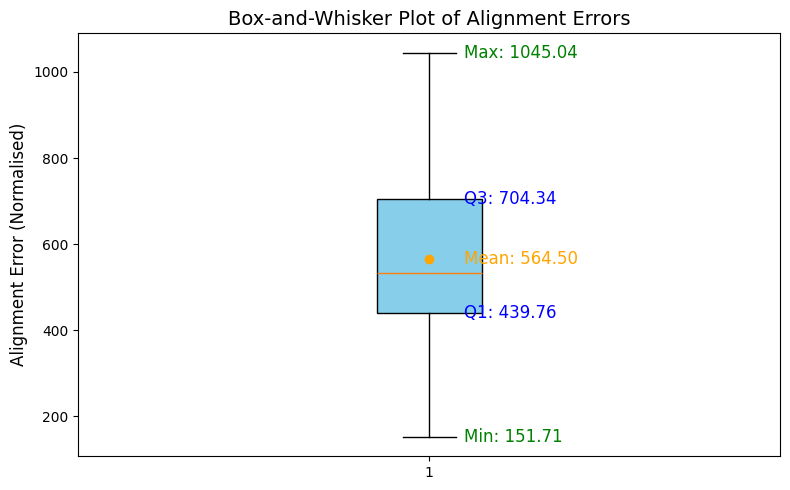

In [7]:
# Plotting the Procrustes distances as box-and-whisker plot for visualisation and analysis

plt.figure(figsize=(8, 5))

mean_error = np.mean(distances)
q1 = np.percentile(distances, 25)  # First quartile (25th percentile)
q3 = np.percentile(distances, 75)  # Third quartile (75th percentile)
min_error = np.min(distances)  # Minimum error (bottom of whiskers)
max_error = np.max(distances)  # Maximum error (top of whiskers)

plt.figure(figsize=(8, 5))

# Create the boxplot
plt.boxplot(distances, patch_artist=True, boxprops=dict(facecolor='skyblue', color='black'),
            whiskerprops=dict(color='black'), flierprops=dict(marker='o', color='red', markersize=5))

# Add the mean error as a label
plt.scatter(1, mean_error, color='orange', zorder=5)  # Place mean as an orange dot
plt.text(1.05, mean_error, f'Mean: {mean_error:.2f}', fontsize=12, color='orange', va='center')

# Add quartile and min/max labels
plt.text(1.05, q1, f'Q1: {q1:.2f}', fontsize=12, color='blue', va='center')
plt.text(1.05, q3, f'Q3: {q3:.2f}', fontsize=12, color='blue', va='center')
plt.text(1.05, min_error, f'Min: {min_error:.2f}', fontsize=12, color='green', va='center')
plt.text(1.05, max_error, f'Max: {max_error:.2f}', fontsize=12, color='green', va='center')

# Title and labels
plt.title("Box-and-Whisker Plot of Alignment Errors", fontsize=14)
plt.ylabel("Alignment Error (Normalised)", fontsize=12)

plt.tight_layout()
plt.show()

4) Visualising the mean shape:
- The line below called other files (main.py) and (biv_plots.py) to plot the mean shape

In [10]:
!python main.py plot biv mean_biventricular_shape_unflattened.txt

5) Performing Principal Component Analysis (PCA) and retrieving n PCs (5 in this case):
- The code accepts the flattened nx1164 patient data and unflattened 388x3 mean shape data
- It outputs the top n PCs (eigenvectors) and the corresponding eigenvalues (to be used for next step)
- It also outputs the corresponding variance ratios for data analysis

In [11]:

def load_and_center_data(mean_shape, aligned_shapes, n_points):
    """
    Center the aligned shapes by subtracting the mean shape.
    """
    # Flatten the mean shape (388 x 3) to a 1D array for easy subtraction
    mean_flattened = mean_shape.flatten()
    
    # Center the data (aligned shapes) by subtracting the mean shape
    centered_data = []
    for shape in aligned_shapes:
        centered_data.append(shape.flatten() - mean_flattened)
    
    centered_data = np.array(centered_data)  # Convert to a numpy array
    return centered_data

def run_pca_analysis(centered_data, n_components):

    # Perform PCA (without standardizing the data)
    pca = PCA(n_components=n_components)
    pca.fit(centered_data)

    # Extract results
    eigenvalues = pca.explained_variance_
    eigenvectors = pca.components_
    variance_ratios = pca.explained_variance_ratio_
    cumulative_variance = variance_ratios.cumsum()

    # Create summary table (avoid name conflict!)
    variance_summary_df = pd.DataFrame({
        'PC': [f"PC{i+1}" for i in range(n_components)],
        'Eigenvalue': eigenvalues,
        'Variance_Ratio': variance_ratios,
        'Cumulative_Variance': cumulative_variance
    })

    # Confirm the shapes
    print(f"Shape of eigenvectors (PCs): {eigenvectors.shape}")
    print(f"Shape of eigenvalues: {eigenvalues.shape}")
    print(f"Shape of variance ratios: {variance_ratios.shape}")

    return eigenvalues, eigenvectors, variance_ratios, cumulative_variance, variance_summary_df

In [12]:
aligned_shapes_array= np.array(aligned_shapes) # Taking aligned shapes from GPA output
PC = 5 # Number of principal components to keep
n_points = 388 # Number of points in the shape (x,y,z)

#Cheacking the shape of the mean shape to make sure it is correct (PC x 1164)
mean_shape = np.loadtxt("mean_biventricular_shape_unflattened.txt", delimiter=",", skiprows=1)  

# Center the data
centered_data = load_and_center_data(mean_shape, aligned_shapes_array, n_points)

# Run PCA on the centered data
eigenvalues, eigenvectors, variance_ratios, cumulative_variance, variance_df = run_pca_analysis(centered_data, PC)

# Print the variance summary
print(variance_df.to_string())


Shape of eigenvectors (PCs): (5, 1164)
Shape of eigenvalues: (5,)
Shape of variance ratios: (5,)
    PC    Eigenvalue  Variance_Ratio  Cumulative_Variance
0  PC1  50283.742680        0.404796             0.404796
1  PC2  35082.607084        0.282423             0.687219
2  PC3  18545.109692        0.149292             0.836512
3  PC4   7605.448647        0.061226             0.897737
4  PC5   1851.818928        0.014908             0.912645


6) Analysing the modes of shape variations from the top n PCs (5 in this case), between +2SD to -2SD:
- The eigenvector (PC) tells the direction of variation.
- The eigenvalue gives the variance magnitude (its square root is the standard deviation).
- Adding/subtracting ±2 × sqrt(eigenvalue) × eigenvector to the mean shape (flattened) gives you shapes at ±2 SD along that PC.

In [13]:
def variation_shapes(mean_shape, eigenvectors, eigenvalues, n_components, n_points, k, output_dir="."):
    """
    mean_shape: Mean shape from GPA
    eigenvectors: Eigenvectors from PCA
    eigenvalues: Eigenvalues from PCA
    n_components: PC from PCA
    n_points: Number of points in the shape from PCA
    
    For each of the top N PCs, generate ± k SD shapes and save them as .txt files.
    """
    mean_flat = mean_shape.flatten()

    for i in range(n_components):
        std_dev = np.sqrt(eigenvalues[i])
        pc_vector = eigenvectors[i]

        # Generate shapes
        minus_2sd = mean_flat - (k * std_dev * pc_vector)
        plus_2sd  = mean_flat + (k * std_dev * pc_vector)

        # Reshape back to (388, 3)
        minus_shape = minus_2sd.reshape(n_points, 3)
        plus_shape  = plus_2sd.reshape(n_points, 3)

        # Save each shape
        minus_filename = f"{output_dir}/PC{i+1}_minus_2SD.txt"
        plus_filename  = f"{output_dir}/PC{i+1}_plus_2SD.txt"

        np.savetxt(minus_filename, minus_shape, delimiter=",", fmt="%.6f", header="X,Y,Z", comments="")
        np.savetxt(plus_filename,  plus_shape,  delimiter=",", fmt="%.6f", header="X,Y,Z", comments="")

        print(f"Saved {minus_filename}")
        print(f"Saved {plus_filename}")


In [14]:
n_components = PC
k = 2
variation_shapes(mean_shape, eigenvectors, eigenvalues, n_components, n_points, k) 


Saved ./PC1_minus_2SD.txt
Saved ./PC1_plus_2SD.txt
Saved ./PC2_minus_2SD.txt
Saved ./PC2_plus_2SD.txt
Saved ./PC3_minus_2SD.txt
Saved ./PC3_plus_2SD.txt
Saved ./PC4_minus_2SD.txt
Saved ./PC4_plus_2SD.txt
Saved ./PC5_minus_2SD.txt
Saved ./PC5_plus_2SD.txt


Visualising the shape variations:

In [15]:
!python main.py plot biv PC1_minus_2SD.txt

# Change 'PC1_minus_2SD.txt' to the name of the file you want to plot
# e.g. 'PC1_plus_2SD.txt', 'PC2_minus_2SD.txt', etc.